<a href="https://colab.research.google.com/github/OlumideF/MScFE_690_Capstone_Student_Group_7139/blob/main/MScFE_690_Capstone_Student_Group_7139_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MScFE Capstone Project
## Student Group 7139



1.   Olumide Babatope Falaba - falanaolumide@gmail.com
2.   Nathaniel Azubuike Nwogwu - nathanielnwogwu@yahoo.com
3.   Paul Akinyemi - akinyepa@clarkson.edu

## **Title: Impact of Covid-19 on Local Markets**
## Research Outline

# Library Installations

In [1]:
pip install yfinance pandas numpy statsmodels arch scipy matplotlib scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 9.1 MB/s eta 0:00:00


# Import Libraries

In [28]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller  # For stationarity test

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model  # For GARCH modeling
import itertools


# Functions to call

In [80]:
# 1.1 Identify and Collect Data Sources
def fetch_market_data(start_date, end_date, ticker_symbol):
    """
    Fetch historical market data for the given ticker symbol between start_date and end_date.
    """
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    return data

# 1.2 Data Cleaning and Preprocessing
def clean_data(df):
    """
    Cleans the data by handling missing values and standardizing formats.
    """
    df.dropna(inplace=True)  # Remove missing values
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure the date column is in datetime format
    df.set_index('Date', inplace=True)  # Set the date column as index
    return df

def detect_and_remove_outliers(df, threshold=3):
    """
    Detects and removes outliers using the Z-score method.
    """
    from scipy.stats import zscore
    df_no_outliers = df[(zscore(df) < threshold).all(axis=1)]
    return df_no_outliers

def normalize_data(df, method='zscore'):
    """
    Normalizes data using the specified method: 'zscore' or 'minmax'.
    """
    if method == 'zscore':
        return (df - df.mean()) / df.std()
    elif method == 'minmax':
        return (df - df.min()) / (df.max() - df.min())
    else:
        raise ValueError("Method should be either 'zscore' or 'minmax'")


# 1.3 Exploratory Data Analysis (EDA)
def plot_time_series(df, title='Time Series Data'):
    """
    Plots time series data.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def calculate_descriptive_stats(df):
    """
    Calculate and return descriptive statistics of the dataset.
    """
    return df.describe()

def test_stationarity(df, method='ADF'):
    """
    Tests for stationarity of the data using the Augmented Dickey-Fuller test.
    """
    result = adfuller(df['Close'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Values: {key}, {value}')
    return result[1]  # Return p-value


# 2.1 Building ARIMA Models
from statsmodels.tsa.arima.model import ARIMA
import itertools

def fit_arima_model(df, order=(1, 1, 1)):
    """
    Fits an ARIMA model to the time series data.
    """
    model = ARIMA(df['Close'], order=order)
    fitted_model = model.fit()
    print(fitted_model.summary())
    return fitted_model

def optimize_arima_params(df):
    """
    Optimizes ARIMA parameters using AIC.
    """
    p = d = q = range(0, 3)
    pdq_combinations = list(itertools.product(p, d, q))
    best_aic = float('inf')
    best_order = None

    for order in pdq_combinations:
        try:
            model = ARIMA(df['Close'], order=order)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
        except:
            continue

    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
    return best_order


# 2.2 Residual Analysis and Validation
def analyze_residuals(model):
    """
    Analyzes the residuals of a fitted ARIMA model.
    """
    residuals = model.resid
    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label='Residuals')
    plt.title('Residuals of ARIMA Model')
    plt.show()
    return residuals

def plot_residuals(residuals):
    """
    Plots the residuals to check for patterns or heteroskedasticity.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(residuals, label='Residuals')
    plt.title('Residuals Analysis')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()


# 2.3 Applying GARCH Models for Volatility Analysis
def fit_garch_model(df, order=(1, 1)):
    """
    Applies a GARCH model to the residuals of the ARIMA model.
    """
    model = arch_model(df['Close'], vol='Garch', p=order[0], q=order[1])
    garch_model = model.fit(disp='off')
    print(garch_model.summary())
    return garch_model

def validate_garch_model(garch_model):
    """
    Validates the GARCH model by checking for ARCH effects.
    """
    test_arch = garch_model.hedgehog_plot()
    return test_arch


# 3.1 Segmenting Data for Pre-Pandemic, Pandemic, and Post-Pandemic Analysis
def segment_data_by_period(df, start_date, end_date):
    """
    Segments the data into specified periods.
    """
    segmented_data = df[(df.index >= start_date) & (df.index <= end_date)]
    return segmented_data


# 3.2 Conducting Comparative Analysis
from scipy.stats import ttest_ind

def compare_volatility_across_periods(data_dict):
    """
    Compares market volatility across different periods.
    """
    volatilities = {period: data['Close'].pct_change().std() for period, data in data_dict.items()}
    print("Volatility comparison across periods:", volatilities)
    return volatilities

def perform_statistical_tests(data1, data2):
    """
    Performs statistical tests to determine significant differences in volatility.
    """
    t_stat, p_value = ttest_ind(data1['Close'].pct_change().dropna(), data2['Close'].pct_change().dropna())
    print(f'T-test results: t-statistic={t_stat}, p-value={p_value}')
    return p_value


# 4.1 Quantifying Volatility Changes
def calculate_volatility_change(pre_pandemic, pandemic, post_pandemic):
    """
    Calculates changes in volatility between pre-pandemic, pandemic, and post-pandemic periods.
    """
    volatility_pre = pre_pandemic['Close'].pct_change().std()
    volatility_pandemic = pandemic['Close'].pct_change().std()
    volatility_post = post_pandemic['Close'].pct_change().std()
    print(f'Pre-pandemic volatility: {volatility_pre}')
    print(f'Pandemic volatility: {volatility_pandemic}')
    print(f'Post-pandemic volatility: {volatility_post}')
    return volatility_pre, volatility_pandemic, volatility_post

def rolling_volatility_analysis(df, window_size=30):
    """
    Analyzes rolling volatility using a specified window size.
    """
    rolling_volatility = df['Close'].pct_change().rolling(window=window_size).std()
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, rolling_volatility, label='Rolling Volatility')
    plt.title('Rolling Volatility Analysis')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()
    return rolling_volatility


# 5.1 Cross-Validation of Models
def cross_validate_arima_model(df, order, k_folds=5):
    """
    Performs cross-validation on ARIMA model using time-series data.

    """
    tscv = TimeSeriesSplit(n_splits=k_folds)
    errors = []

    for train_index, test_index in tscv.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]

        # Fit the ARIMA model on the training data
        model = ARIMA(train['Close'], order=order)
        fitted_model = model.fit()

        # Forecast on the test set
        predictions = fitted_model.forecast(steps=len(test))
        error = np.mean((predictions - test['Close']) ** 2)  # Mean Squared Error
        errors.append(error)

    mean_error = np.mean(errors)
    print("Cross-validation Mean Squared Error (MSE):", mean_error)
    return mean_error


def sensitivity_analysis_arima(df, base_order=(1, 1, 1), variations=[(-1, 0, 0), (0, -1, 0), (0, 0, -1)]):
    """
    Conducts sensitivity analysis on ARIMA model parameters.

    """
    results = {}
    p, d, q = base_order

    for variation in variations:
        var_order = (p + variation[0], d + variation[1], q + variation[2])
        try:
            model = ARIMA(df['Close'], order=var_order)
            fitted_model = model.fit()
            results[var_order] = {'AIC': fitted_model.aic, 'BIC': fitted_model.bic}
            print(f"Order {var_order} - AIC: {fitted_model.aic}, BIC: {fitted_model.bic}")
        except:
            print(f"Order {var_order} is not a valid model.")
            continue

    return results


# 5.2 Comparing Models' Performance
def compare_model_performance(models, metrics=['AIC', 'BIC', 'MSE']):
    """
    Compares different models' performance based on specified metrics.

    """
    performance = {metric: [] for metric in metrics}

    for model in models:
        # Handle ARIMA models
        if isinstance(model, ARIMA) or isinstance(model, ARIMA.ARIMAResultsWrapper):
            if 'AIC' in metrics:
                performance['AIC'].append(model.aic)
            if 'BIC' in metrics:
                performance['BIC'].append(model.bic)
            if 'MSE' in metrics:
                # Forecast for ARIMA models
                predictions = model.predict(start=0, end=len(model.data.endog)-1)
                mse = np.mean((predictions - model.data.endog) ** 2)
                performance['MSE'].append(mse)

        # Handle GARCH models
        elif hasattr(model, 'forecast'):
            if 'AIC' in metrics:
                performance['AIC'].append(model.aic)
            if 'BIC' in metrics:
                performance['BIC'].append(model.bic)
            if 'MSE' in metrics:
                # Forecast for GARCH models
                forecasts = model.forecast(horizon=1)
                predicted_variance = forecasts.variance.iloc[-1]  # Correct extraction
                actual_returns = model.model.resids[-len(predicted_variance):]
                mse = np.mean((predicted_variance.values - actual_returns ** 2) ** 2)
                performance['MSE'].append(mse)

    print("Model Performance Comparison:")
    for metric in metrics:
        print(f"{metric}: {performance[metric]}")

    return performance


# 6.1 Summarizing Findings
def generate_summary_statistics(df):
    """
    Generates summary statistics of the dataset.
    """
    summary = df.describe()
    print("Summary Statistics:", summary)
    return summary

def generate_report(df, models, insights):
    """
    Generate a comprehensive report summarizing the findings.
    """
    report = {
        'Data Summary': generate_summary_statistics(df),
        'Model Insights': {model_name: model.summary() for model_name, model in models.items()},
        'Key Insights': insights
    }
    return report

# 6.2 Visualizing Results
def visualize_results(data_dict):
    """
    Generates visual aids to communicate key findings.
    """
    for key, data in data_dict.items():
        plt.figure(figsize=(10, 5))
        plt.plot(data.index, data['Close'], label=f'{key} Close Prices')
        plt.title(f'{key} Period Close Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()




# Step 1: Fetch and clean data
## 1. Data Collection and Preparation

In [95]:
# Fetch market data for S&P 500
def fetch_sp500_data(start_date, end_date):
    """
    Fetches historical S&P 500 data from Yahoo Finance.
    """
    sp500_data = yf.download('^GSPC', start=start_date, end=end_date)
    sp500_data.reset_index(inplace=True)
    return sp500_data



# Data cleaning

In [96]:
def clean_data(df):
    """
    Cleans the data by handling missing values and standardizing formats.
    """
    df.dropna(inplace=True)  # Remove missing values
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure the date column is in datetime format
    df.set_index('Date', inplace=True)  # Set the date column as index
    return df
# Fetch and clean data
start_date = '2017-01-01'
end_date = '2024-09-01'
sp500_data = fetch_sp500_data(start_date, end_date)
sp500_data_cleaned = clean_data(sp500_data)

[*********************100%***********************]  1 of 1 completed


In [97]:
sp500_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000
...,...,...,...,...,...,...
2024-08-26,5639.660156,5651.620117,5602.339844,5616.839844,5616.839844,2938570000
2024-08-27,5602.890137,5631.180176,5593.479980,5625.799805,5625.799805,2798990000
2024-08-28,5624.509766,5627.029785,5560.950195,5592.180176,5592.180176,3053450000


In [98]:
sp500_data_cleaned

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000
...,...,...,...,...,...,...
2024-08-26,5639.660156,5651.620117,5602.339844,5616.839844,5616.839844,2938570000
2024-08-27,5602.890137,5631.180176,5593.479980,5625.799805,5625.799805,2798990000
2024-08-28,5624.509766,5627.029785,5560.950195,5592.180176,5592.180176,3053450000


# Step 2: Perform Exploratory Data Analysis (EDA)

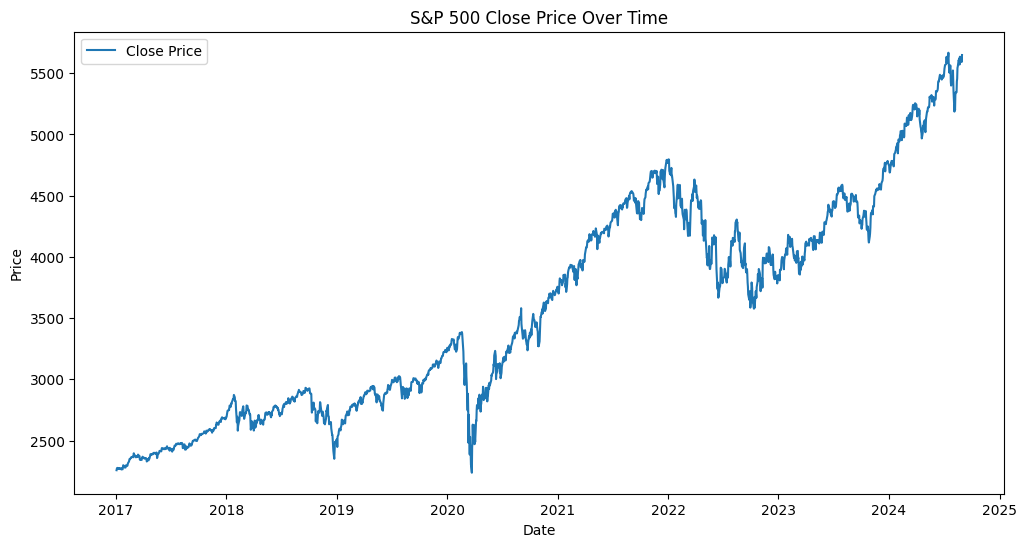

ADF Statistic: -0.11174850526483021
p-value: 0.9482556909017372
Critical Values: 1%, -3.4337657944732745
Critical Values: 5%, -2.863048878223751
Critical Values: 10%, -2.567573268289192


In [99]:
plot_time_series(sp500_data_cleaned, 'S&P 500 Close Price Over Time')
calculate_descriptive_stats(sp500_data_cleaned)
stationarity_p_value = test_stationarity(sp500_data_cleaned)


# Step 3: Fit ARIMA and GARCH Models

In [100]:
arima_order = optimize_arima_params(sp500_data_cleaned)
arima_model = fit_arima_model(sp500_data_cleaned, arima_order)
garch_model = fit_garch_model(sp500_data_cleaned)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA order: (2, 1, 2) with AIC: 19665.50213460611


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1928
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9827.751
Date:                Tue, 17 Sep 2024   AIC                          19665.502
Time:                        15:44:44   BIC                          19693.321
Sample:                             0   HQIC                         19675.736
                               - 1928                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7586      0.025    -71.522      0.000      -1.807      -1.710
ar.L2         -0.8777      0.023    -37.784      0.000      -0.923      -0.832
ma.L1          1.6866      0.031     55.127      0.0

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.827e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -15069.5
Distribution:                  Normal   AIC:                           30147.0
Method:            Maximum Likelihood   BIC:                           30169.3
                                        No. Observations:                 1928
Date:                Tue, Sep 17 2024   Df Residuals:                     1927
Time:                        15:44:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu          3965.9798      8.229    481.950      0.000 [3.

# Step 4: Perform Cross-Validation on ARIMA model

In [101]:
arima_order = (1, 1, 1)
cross_validate_arima_model(sp500_data_cleaned, arima_order)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Cross-validation Mean Squared Error (MSE): nan


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


nan

# Step 5: Conduct Sensitivity Analysis

In [109]:
sensitivity_results = sensitivity_analysis_arima(sp500_data_cleaned, base_order=arima_order)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Order (0, 1, 1) - AIC: 19725.042199384705, BIC: 19736.169638721534


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Order (1, 0, 1) - AIC: 19747.739344774745, BIC: 19769.99629867543
Order (1, 1, 0) - AIC: 19723.802767808316, BIC: 19734.930207145146


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Step 6: Compare Model Performance

In [110]:
arima_model = fit_arima_model(sp500_data_cleaned, arima_order)
garch_model = fit_garch_model(sp500_data_cleaned)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1928
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9858.488
Date:                Tue, 17 Sep 2024   AIC                          19722.976
Time:                        15:50:48   BIC                          19739.667
Sample:                             0   HQIC                         19729.116
                               - 1928                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3928      0.104     -3.766      0.000      -0.597      -0.188
ma.L1          0.3040      0.109      2.789      0.005       0.090       0.518
sigma2      1628.6017     27.980     58.206      0.0

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.827e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


# Step 7: Segment data for comparative analysis
We will segment the data into pre-pandemic, pandemic, and post-pandemic periods and compare volatility

In [111]:
pre_pandemic_data = segment_data_by_period(sp500_data_cleaned, '2017-01-01', '2020-03-01')
pandemic_data = segment_data_by_period(sp500_data_cleaned, '2020-03-01', '2021-06-01')
post_pandemic_data = segment_data_by_period(sp500_data_cleaned, '2021-06-01', '2024-09-01')


# Step 8: Quantify Volatility Changes
Quantify changes in volatility across periods

Pre-pandemic volatility: 0.008325425089256181
Pandemic volatility: 0.019458319142878364
Post-pandemic volatility: 0.010756389772821942


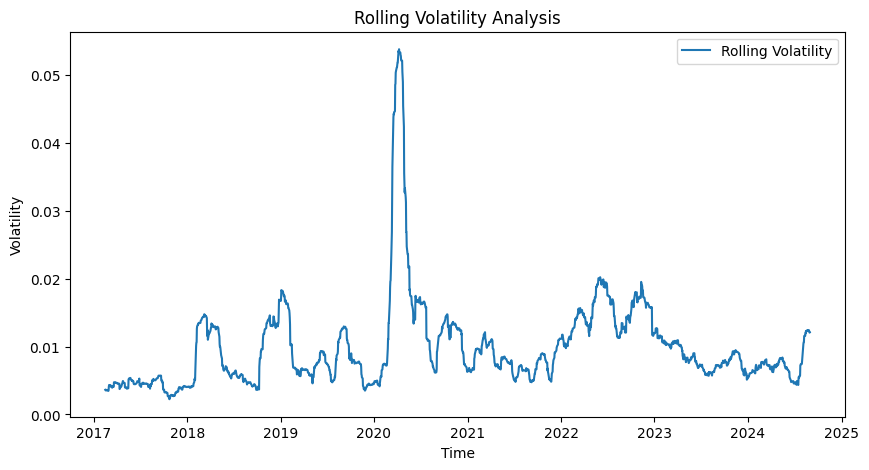

,Close
Date,
2017-01-03,NaN
2017-01-04,NaN
2017-01-05,NaN
2017-01-06,NaN
2017-01-09,NaN
...,...
2024-08-26,0.012415
2024-08-27,0.012361
2024-08-28,0.012139


In [112]:
calculate_volatility_change(pre_pandemic_data, pandemic_data, post_pandemic_data)
rolling_volatility_analysis(sp500_data_cleaned)

# Step 9: Comparative Analysis

In [113]:
data_periods = {'Pre-Pandemic': pre_pandemic_data, 'Pandemic': pandemic_data, 'Post-Pandemic': post_pandemic_data}
compare_volatility_across_periods(data_periods)
perform_statistical_tests(pre_pandemic_data, pandemic_data)

Volatility comparison across periods: {'Pre-Pandemic': 0.008325425089256181, 'Pandemic': 0.019458319142878364, 'Post-Pandemic': 0.010756389772821942}
T-test results: t-statistic=-0.9496339859436461, p-value=0.3425057202917764


0.3425057202917764

### Generate Insights and Visualize Results

In [114]:
# summary
summary_stats = generate_summary_statistics(sp500_data_cleaned)
summary_stats

Summary Statistics:               Open         High          Low        Close    Adj Close  \
count  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000   
mean   3581.467719  3601.084768  3560.602364  3582.102335  3582.102335   
std     884.552498   889.219281   880.222440   884.943627   884.943627   
min    2251.570068  2263.879883  2191.860107  2237.399902  2237.399902   
25%    2786.604980  2796.269958  2767.567444  2783.967468  2783.967468   
50%    3507.890015  3527.984985  3485.040039  3508.724976  3508.724976   
75%    4308.707397  4337.257324  4275.587402  4305.465088  4305.465088   
max    5644.089844  5669.669922  5639.020020  5667.200195  5667.200195   

             Volume  
count  1.928000e+03  
mean   4.068725e+09  
std    9.964339e+08  
min    1.296530e+09  
25%    3.459325e+09  
50%    3.856720e+09  
75%    4.432690e+09  
max    9.976520e+09  


,Open,High,Low,Close,Adj Close,Volume
count,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000,1.928000e+03
mean,3581.467719,3601.084768,3560.602364,3582.102335,3582.102335,4.068725e+09
std,884.552498,889.219281,880.222440,884.943627,884.943627,9.964339e+08
min,2251.570068,2263.879883,2191.860107,2237.399902,2237.399902,1.296530e+09
25%,2786.604980,2796.269958,2767.567444,2783.967468,2783.967468,3.459325e+09
50%,3507.890015,3527.984985,3485.040039,3508.724976,3508.724976,3.856720e+09
75%,4308.707397,4337.257324,4275.587402,4305.465088,4305.465088,4.432690e+09
max,5644.089844,5669.669922,5639.020020,5667.200195,5667.200195,9.976520e+09


In [118]:

report = generate_report(sp500_data_cleaned, {'ARIMA': arima_model, 'GARCH': garch_model}, insights='COVID-19 significantly increased market volatility.') # also check ARIMA(3, 1, 4)
report


Summary Statistics:               Open         High          Low        Close    Adj Close  \
count  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000   
mean   3581.467719  3601.084768  3560.602364  3582.102335  3582.102335   
std     884.552498   889.219281   880.222440   884.943627   884.943627   
min    2251.570068  2263.879883  2191.860107  2237.399902  2237.399902   
25%    2786.604980  2796.269958  2767.567444  2783.967468  2783.967468   
50%    3507.890015  3527.984985  3485.040039  3508.724976  3508.724976   
75%    4308.707397  4337.257324  4275.587402  4305.465088  4305.465088   
max    5644.089844  5669.669922  5639.020020  5667.200195  5667.200195   

             Volume  
count  1.928000e+03  
mean   4.068725e+09  
std    9.964339e+08  
min    1.296530e+09  
25%    3.459325e+09  
50%    3.856720e+09  
75%    4.432690e+09  
max    9.976520e+09  


{'Data Summary':               Open         High          Low        Close    Adj Close  \
 count  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000   
 mean   3581.467719  3601.084768  3560.602364  3582.102335  3582.102335   
 std     884.552498   889.219281   880.222440   884.943627   884.943627   
 min    2251.570068  2263.879883  2191.860107  2237.399902  2237.399902   
 25%    2786.604980  2796.269958  2767.567444  2783.967468  2783.967468   
 50%    3507.890015  3527.984985  3485.040039  3508.724976  3508.724976   
 75%    4308.707397  4337.257324  4275.587402  4305.465088  4305.465088   
 max    5644.089844  5669.669922  5639.020020  5667.200195  5667.200195   
 
              Volume  
 count  1.928000e+03  
 mean   4.068725e+09  
 std    9.964339e+08  
 min    1.296530e+09  
 25%    3.459325e+09  
 50%    3.856720e+09  
 75%    4.432690e+09  
 max    9.976520e+09  ,
 'Model Insights': {'ARIMA': <class 'statsmodels.iolib.summary.Summary'>
  """
                    

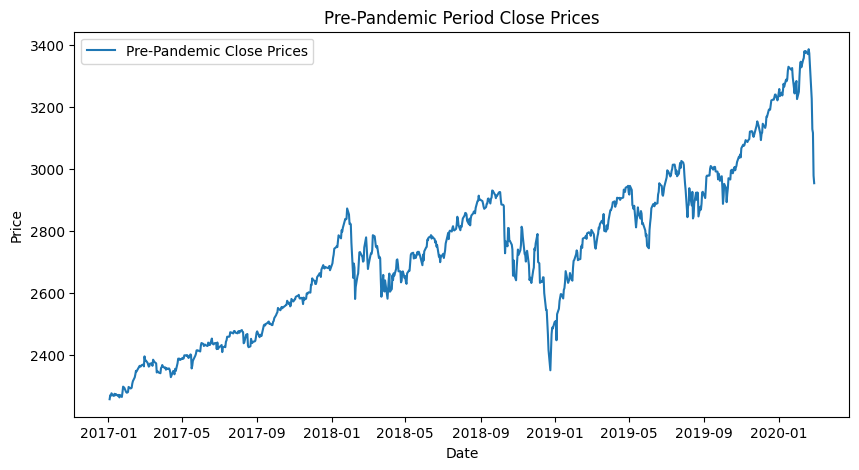

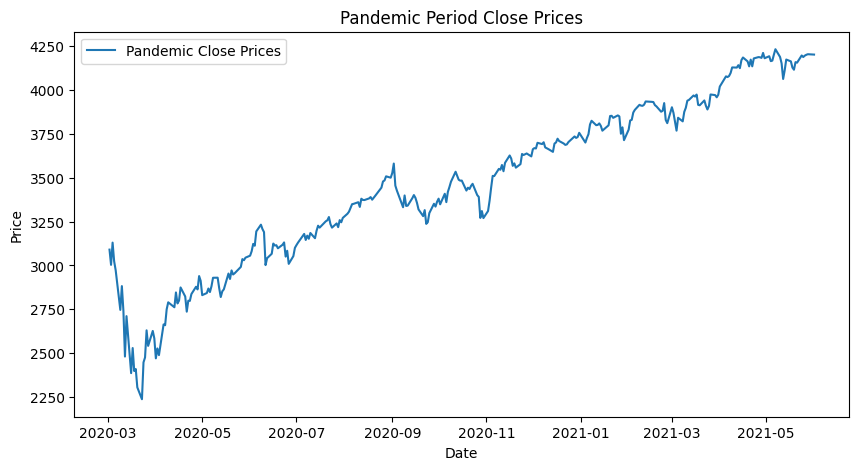

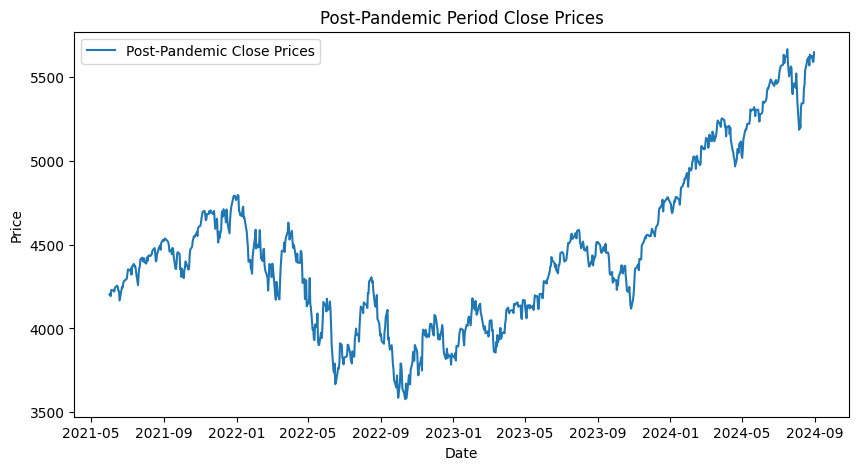

In [119]:
# Visualize results
visualize_results({'Pre-Pandemic': pre_pandemic_data, 'Pandemic': pandemic_data, 'Post-Pandemic': post_pandemic_data})